In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # INFO, WARNING messages are not printed
import tensorflow as tf
import time # for throughput measurements

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

# uninstall sionna first
import sys
from pathlib import Path

sys.path.append(str(Path('..')))

from sionna.fec.ldpc import *
from sionna.utils import BinarySource 
from sionna.utils.metrics import count_block_errors
from sionna.channel import Pauli
from sionna.utils.plotting import PlotBER

from tensorflow.keras.losses import BinaryCrossentropy
from sionna.utils.metrics import compute_bler
from sionna.fec.utils import int_mod_2


Number of GPUs available : 1
Only GPU number 0 used.


In [2]:
class BP4_Error_Model(tf.keras.Model):
# For storing error strings that the BP decoder failed to decode
    def __init__(self, code, decoder, num_iter=32, trainable=False, loss_type="boxplus-phi", wt=False):

        super().__init__()
        
        self.k = code.K      
        self.n = code.N
        self.hx = code.hx
        self.hz = code.hz
        self.lx = code.lx
        self.lz = code.lz
        self.hx_perp = code.hx_perp # contains Im(hz.T)
        self.hz_perp = code.hz_perp # contains Im(hx.T)
        self.code_name = code.name
        self.num_checks = code.hx.shape[0] + code.hz.shape[0]
        
        self.source = BinarySource()
        self.channel = Pauli(wt=wt)
        self.decoder = decoder

        self.num_iter = num_iter
        self.trainable = trainable
        self.bce = BinaryCrossentropy(from_logits=True)
        self.loss_type = loss_type
        self.wt = wt
           
    @tf.function(jit_compile=True, reduce_retracing=True) # XLA mode
    def call(self, batch_size, ebno_db):

        p = ebno_db

        # depolarizing noise
        px, py, pz = 2*p/3, p/3, 2*p/3
        c_dummy = tf.zeros([batch_size, self.n])
        if self.wt: # ebno_db is an integer indicating the weight of the error
            noise_x, noise_z = self.channel([c_dummy, None, p])
        else:
            noise_x, noise_z = self.channel([c_dummy, None, px, py, pz])  # [bs, self.n]
        noise_x_T, noise_z_T = tf.transpose(noise_x, (1,0)), tf.transpose(noise_z, (1,0))
        noise_x_int = tf.cast(noise_x_T, self.hz.dtype)
        noise_z_int = tf.cast(noise_z_T, self.hx.dtype)
        syndrome_x = int_mod_2(tf.matmul(self.hx, noise_z_int))
        syndrome_z = int_mod_2(tf.matmul(self.hz, noise_x_int))

        p0 = 0.05 
        llr_ch_x = tf.fill(tf.shape(noise_x), tf.math.log(3.*(1.-p0)/p0))
        llr = tf.tile(tf.expand_dims(llr_ch_x, axis=1), multiples=tf.constant([1, 3, 1], tf.int32))
        # shape of llr: [bs, 3, self.n]
        
        x_hat, z_hat = self.decoder((llr, syndrome_x, syndrome_z))
        
        x_hat = tf.transpose(tf.cast(x_hat, tf.bool), (1,0)) # [self.n, bs]
        z_hat = tf.transpose(tf.cast(z_hat, tf.bool), (1,0))

        x_diff = tf.cast(tf.math.logical_xor(noise_x_T, x_hat), self.hx_perp.dtype)
        z_diff = tf.cast(tf.math.logical_xor(noise_z_T, z_hat), self.hz_perp.dtype)

        sx = int_mod_2(tf.matmul(self.hz, x_diff))
        sz = int_mod_2(tf.matmul(self.hx, z_diff))
        s_hat = tf.concat([sx, sz], axis=0)
        s_hat = tf.transpose(s_hat, (1,0))
        err = tf.reduce_any(tf.not_equal(tf.zeros_like(s_hat), s_hat), axis=-1)
        return noise_x[err], noise_z[err]


class Feedback_GNN_Error_Model(tf.keras.Model):
# For storing error strings that the (BP, feedback_GNN, BP) decoder failed to decode
    def __init__(self, code, decoder1, feedback, decoder2, wt=False, p0=0.05):

        super().__init__()
        
        self.k = code.K      
        self.n = code.N
        self.hx = code.hx # [cn, n]
        self.hz = code.hz
        self.lx = code.lx
        self.lz = code.lz

        self.hx_perp = code.hx_perp
        self.hz_perp = code.hz_perp
        self.code_name = code.name
        self.num_checks = code.hx.shape[0] + code.hz.shape[0]
  
        self.source = BinarySource()
        self.channel = Pauli(wt=wt)
        
        self.decoder1 = decoder1
        self.feedback = feedback
        self.decoder2 = decoder2

        self.wt = wt
        self.p0 = p0
        
      
    @tf.function(jit_compile=True, reduce_retracing=True) # XLA mode during evaluation
    def call(self, batch_size, ebno_db):
#     def call(self, noise_x, noise_z):

        p = ebno_db
        c_dummy = tf.zeros([batch_size, self.n])
        if self.wt: # p is the weight of the error strings
            noise_x, noise_z = self.channel([c_dummy, None, p])
        else:
            # depolarizing noise
            px, py, pz = 2*p/3, p/3, 2*p/3
            noise_x, noise_z = self.channel([c_dummy, None, px, py, pz])  # [bs, self.n]
            
        noise_x_T, noise_z_T = tf.transpose(noise_x, (1,0)), tf.transpose(noise_z, (1,0))
        noise_x_int = tf.cast(noise_x_T, self.hz.dtype)
        noise_z_int = tf.cast(noise_z_T, self.hx.dtype)
        syndrome_x = int_mod_2(tf.matmul(self.hx, noise_z_int))
        syndrome_z = int_mod_2(tf.matmul(self.hz, noise_x_int))

        p0 = self.p0 
        llr_ch_x = tf.fill(tf.shape(noise_x), tf.math.log(3.*(1.-p0)/p0))
        llr = tf.tile(tf.expand_dims(llr_ch_x, axis=1), multiples=tf.constant([1, 3, 1], tf.int32))
        # shape of llr: [bs, 3, self.n]
        gt_x = int_mod_2(tf.matmul(self.hz, noise_x_int)) # [cn, bs]
        gt_z = int_mod_2(tf.matmul(self.hx, noise_z_int))
        
        gt = tf.concat([gt_x, gt_z], axis=0) # [cn_x+cn_z, bs]
        gt = tf.transpose(gt, (1,0))         # [bs, cn_x+cn_z]        
       
        # two-stage decoding, with GNN feedback in the middle
        llrx, llry, llrz, x_hat_stage_one, z_hat_stage_one, logit_hx_perp, logit_hz_perp = self.decoder1((llr, syndrome_x, syndrome_z))

        sx = int_mod_2(tf.matmul(self.hz, tf.transpose(tf.cast(x_hat_stage_one, self.hz.dtype), (1,0)))) # [cn, bs]
        sz = int_mod_2(tf.matmul(self.hx, tf.transpose(tf.cast(z_hat_stage_one, self.hx.dtype), (1,0))))
        
        # find where flagged errors happened during first stage
        s_hat = tf.transpose(tf.concat([sx, sz], axis=0), (1,0)) # [bs, cn_x+cn_z]
        errors = tf.reduce_any(tf.not_equal(gt, s_hat), axis=-1)
                      
        h_vn = tf.stack([llrx, llry, llrz], axis=-1) # [bs, n, 3] GNN variable node values
        
        new_llr = self.feedback((h_vn, logit_hz_perp, logit_hx_perp, syndrome_x, syndrome_z))
           
        x_hat_stage_two, z_hat_stage_two = self.decoder2((tf.transpose(new_llr, (0,2,1)), syndrome_x, syndrome_z))

        # update the second-stage results for where flagged errors happened
        x_hat = tf.tensor_scatter_nd_update(x_hat_stage_one, tf.where(errors), x_hat_stage_two[errors])
        z_hat = tf.tensor_scatter_nd_update(z_hat_stage_one, tf.where(errors), z_hat_stage_two[errors])         
            
        x_hat = tf.transpose(tf.cast(x_hat, tf.bool), (1,0)) # [self.n, bs]
        z_hat = tf.transpose(tf.cast(z_hat, tf.bool), (1,0))

        x_diff = tf.cast(tf.math.logical_xor(noise_x_T, x_hat), self.hx.dtype)
        z_diff = tf.cast(tf.math.logical_xor(noise_z_T, z_hat), self.hz.dtype)

        sx = int_mod_2(tf.matmul(self.hz, x_diff))
        sz = int_mod_2(tf.matmul(self.hx, z_diff))
        s_hat = tf.concat([sx, sz], axis=0)
        s_hat = tf.transpose(s_hat, (1,0))
        err = tf.reduce_any(tf.not_equal(tf.zeros_like(s_hat), s_hat), axis=-1)
        return noise_x[err], noise_z[err]

In [10]:
from pathlib import Path

def make_dataset(suffix="", wt_from=0, wt_to=40, level="easy"):
    directory = '../sionna/fec/ldpc/datasets'
    files = Path(directory).glob('*')
    dataset_x = []
    dataset_z = []
    for file in files:
        if not file.name.startswith(suffix):
            continue
        if not file.name.endswith('_x.npy'):
            continue
        wt = int(file.name.split('_')[-2][2:])
        if wt_from <= wt and wt <= wt_to:
            dataset_x.append(np.load(file))
            file_z = file.name.replace('x', 'z')
            dataset_z.append(np.load(directory+'/'+file_z))
    dataset_x = np.vstack(dataset_x)
    dataset_z = np.vstack(dataset_z)
    print("dataset x shape", dataset_x.shape)
    dir_x = Path(directory+f'/{suffix}_wt_{wt_from}_{wt_to}_x_{level}.npy')
    dir_z = Path(directory+f'/{suffix}_wt_{wt_from}_{wt_to}_z_{level}.npy')
    
    if Path(dir_x).exists():
        print(f"{dir_x} exists, adding new data to it")
        dataset_x = np.vstack([dataset_x, np.load(dir_x)])
        
    print(f"saving dataset x of shape {dataset_x.shape} to {dir_x}")
    np.save(dir_x, dataset_x)
    
    if Path(dir_z).exists():
        print(f"{dir_z} exists, adding new data to it")
        dataset_z = np.vstack([dataset_z, np.load(dir_z)])
        
    print(f"saving dataset z of shape {dataset_z.shape} to {dir_z}")
    np.save(dir_z, dataset_z)
    


## Making the easy dataset
Store error strings that a 64-iteration BP failed to decode.

In [9]:
# GHP_n882_k24 = create_QC_GHP_codes(63, create_cyclic_permuting_matrix(7, [27,54,0]), [0,1,6]) # 18 <= d <= 24
# code = GHP_n882_k24
GHP_n1270_k28 = create_QC_GHP_codes(127, np.array([[0,-1,51,52,-1],[-1,0,-1,111,20],[0,-1,98,-1,122],[0,80,-1,119,-1],[-1,0,5,-1,106]]), [0,1,7], name="GHP_n1270_k28") # 16 <= d <= 46
code = GHP_n1270_k28

num_iter = 64
decoder = QLDPCBPDecoder(code=code, num_iter=num_iter, normalization_factor=1.0, cn_type="boxplus-phi")
model = BP4_Error_Model(code, decoder, num_iter=tf.constant(num_iter), trainable=False, wt=True)

In [ ]:
# Run this cell multiple times
batch_size = tf.constant(50000)
training_pipeline = zip(range(10, 61), [50]*51) # 1270
# training_pipeline = zip(range(4, 41), [50]*37) # 882

for wt, train_iter in training_pipeline:
    print(f"weight {wt}, find BP failed-to-decode samples for {train_iter} iterations.")
    wt = tf.constant(wt)
    sample_x_list = []
    sample_z_list = []
    for _ in range(0, train_iter):
        noise_x, noise_z = model(batch_size, wt)
        sample_x_list.append(noise_x)
        sample_z_list.append(noise_z)
        
    np.save(f"../sionna/fec/ldpc/datasets/n1270_k28_wt{wt}_x.npy", np.vstack(sample_x_list))
    np.save(f"../sionna/fec/ldpc/datasets/n1270_k28_wt{wt}_z.npy", np.vstack(sample_z_list))   
    
#     np.save(f"../sionna/fec/ldpc/datasets/n882_k24_wt{wt}_x.npy", np.vstack(sample_x_list))
#     np.save(f"../sionna/fec/ldpc/datasets/n882_k24_wt{wt}_z.npy", np.vstack(sample_z_list))   

make_dataset(suffix="n1270_k28", wt_from=10, wt_to=60, level="easy")
# make_dataset(suffix="n882_k24", wt_from=4, wt_to=40, level="easy")

### Go to Feedback_GNN.ipynb 
- Replace the dataset there by the easy dataset you generated, e.g. `../sionna/fec/ldpc/datasets/n1270_k28_wt_10_60_x_easy.npy`.
- Change num_iter1 from 64 to 16. Leave num_iter2 as 16. I.e., the feedback GNN is sandwiched between two 16-iteration BP blocks.
- Train a coarse feedback GNN model and save it as e.g. `../sionna/fec/ldpc/weights/feedback_GNN_n1270_k28_wt_10_60_iter_16_16.npy`

## Making the hard-to-decode dataset 
Store error strings that a feedback GNN sandwiched between two 64-iteration BP blocks failed to decode.

In [ ]:
GHP_n1270_k28 = create_QC_GHP_codes(127, np.array([[0,-1,51,52,-1],[-1,0,-1,111,20],[0,-1,98,-1,122],[0,80,-1,119,-1],[-1,0,5,-1,106]]), [0,1,7], name="GHP_n1270_k28") # 16 <= d <= 46
code = GHP_n1270_k28

# GHP_n882_k24 = create_QC_GHP_codes(63, create_cyclic_permuting_matrix(7, [27,54,0]), [0,1,6]) # 18 <= d <= 24
# code = GHP_n882_k24

############## load model ########################
feedback_GNN = Feedback_GNN(code=code, 
                 num_msg_dims=tf.constant(20),
                 num_hidden_units=tf.constant(40),
                 num_mlp_layers=2,
                 reduce_op="mean",      ######### change here
                 activation="tanh",
                 use_bias=True)

bs = tf.constant(100)
n = tf.constant(code.N)
cn_z = tf.constant(code.hz.shape[0])
cn_x = tf.constant(code.hx.shape[0])
feedback_GNN((tf.zeros((bs, n, 3)), tf.zeros((cn_x, bs)), tf.zeros((cn_z, bs)), 
                  tf.zeros((cn_x, bs)), tf.zeros((cn_z, bs))))

# load the trained coarse GNN
load_weights(feedback_GNN, f"../sionna/fec/ldpc/weights/feedback_GNN_n1270_k28_wt_10_60_iter_16_16.npy")
# load_weights(feedback_GNN, f"../sionna/fec/ldpc/weights/feedback_GNN_n882_k24_wt_4_40_iter_16_16.npy")
##################################################

num_iter1 = tf.constant(64)
num_iter2 = tf.constant(64)
factor1 = tf.constant(1.0)
factor2 = tf.constant(1.0)
decoder1 = QLDPCBPDecoder(code=code, num_iter=num_iter1, normalization_factor=factor1, cn_type="boxplus-phi", trainable=False, stage_one=True)
decoder2 = QLDPCBPDecoder(code=code, num_iter=num_iter2, normalization_factor=factor2, cn_type="boxplus-phi", trainable=False)
model = Feedback_GNN_Error_Model(code, decoder1, feedback_GNN, decoder2, wt=True)

## 1270 Dataset contains 
- easy: 867278 samples of weight 10-60, 856 samples of weight 61-80.
- hard: 5779 samples of weight 10-60, 3000 samples of weight 61-80. Repeated for 50 times.

In [ ]:
# run this cell until you gathered ~10K samples
batch_size = tf.constant(5000)
training_pipeline = zip(range(10, 81)[::-1], [200]*71)

for wt, train_iter in training_pipeline:
    print(f"weight {wt}, find two-stage difficult samples for {train_iter} iterations.")
    wt = tf.constant(wt)
    sample_x_list = []
    sample_z_list = []
    for _ in range(0, train_iter):
        noise_x, noise_z = model(batch_size, wt)
        sample_x_list.append(noise_x)
        sample_z_list.append(noise_z)
    np.save(f"../sionna/fec/ldpc/datasets/n1270_k28_wt{wt}_x.npy", np.vstack(sample_x_list))
    np.save(f"../sionna/fec/ldpc/datasets/n1270_k28_wt{wt}_z.npy", np.vstack(sample_z_list))  
    
make_dataset("n1270_k28", 10, 80, 'hard')

Looking at the distribution of the dataset, we notice that there are too many error strings of weight 61-80. Therefore, we split the dataset into two, weight 10-60 and weight 61-80 and only select 3000 samples from the latter.

(13847, 1270)
(13847, 1270)
(13847,)


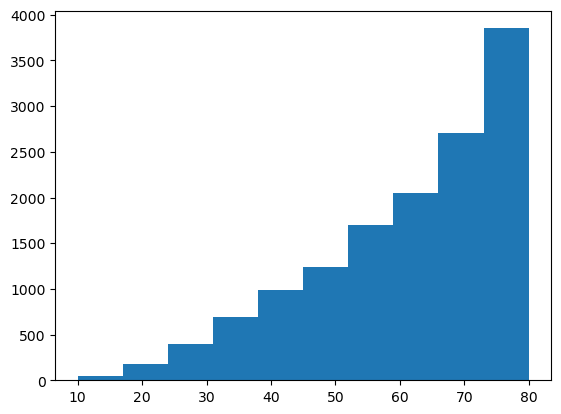

In [5]:
x = np.load("../sionna/fec/ldpc/datasets/n1270_k28_wt_10_80_x_hard.npy")
z = np.load("../sionna/fec/ldpc/datasets/n1270_k28_wt_10_80_z_hard.npy")
print(x.shape)
print(z.shape)
a = np.logical_or(x, z)
wt = np.sum(a, axis=1)
print(wt.shape)
plt.hist(wt)

min_wt = 10
max_wt = 60
mask = np.logical_and(wt<=max_wt, wt>=min_wt)
np.save(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_{min_wt}_{max_wt}_x_hard.npy", x[mask])
np.save(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_{min_wt}_{max_wt}_z_hard.npy", z[mask])

min_wt = 61
max_wt = 80
mask = np.logical_and(wt<=max_wt, wt>=min_wt)
np.save(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_{min_wt}_{max_wt}_x_hard.npy", x[mask])
np.save(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_{min_wt}_{max_wt}_z_hard.npy", z[mask])

In [17]:
dx_10_60_hard = np.load(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_10_60_x_hard.npy")
dz_10_60_hard = np.load(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_10_60_z_hard.npy")

dx_61_80_hard = np.load(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_61_80_x_hard.npy")
dz_61_80_hard = np.load(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_61_80_z_hard.npy")

mask = np.random.choice(dx_61_80_hard.shape[0], 3000, replace=False)

dx_61_80_hard = dx_61_80_hard[mask,:]
dz_61_80_hard = dz_61_80_hard[mask,:]

dx_10_60_easy = np.load(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_10_60_x_easy.npy")
dz_10_60_easy = np.load(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_10_60_z_easy.npy")

# (optional) generate some easy samples of weight 61-80
dx_61_80_easy = np.load(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_61_80_x_easy.npy")
dz_61_80_easy = np.load(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_61_80_z_easy.npy")

print(dx_10_60_hard.shape)
print(dx_61_80_hard.shape)
print(dx_61_80_easy.shape)
print(dx_10_60_easy.shape)

dx_all = np.vstack([dx_10_60_easy]+[dx_61_80_easy]+[dx_10_60_hard]*50+[dx_61_80_hard]*50)
dz_all = np.vstack([dz_10_60_easy]+[dz_61_80_easy]+[dz_10_60_hard]*50+[dz_61_80_hard]*50)
print(dx_all.shape)

np.save(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_10_80_x_all.npy", dx_all)
np.save(f"../sionna/fec/ldpc/datasets/n1270_k28_wt_10_80_z_all.npy", dz_all)

(5779, 1270)
(3000, 1270)
(856, 1270)
(867278, 1270)
(1307084, 1270)


## 882 Dataset contains 
- easy: 439916 samples of weight 4-40, 300000 samples of weight 41-60.
- hard: 6912 samples of weight 4-40, 4032 samples of weight 41-60. Repeated for 50 times.

In [ ]:
# This time, split the hard dataset generation into weight 4-40 and weight 41-60.
# Run this cell multiple times
batch_size = tf.constant(5000)
training_pipeline = zip(range(41, 61)[::-1], [200]*20)
# training_pipeline = zip(range(4, 40)[::-1], [200]*36)

for wt, train_iter in training_pipeline:
    print(f"weight {wt}, find two-stage difficult samples for {train_iter} iterations.")
    wt = tf.constant(wt)
    sample_x_list = []
    sample_z_list = []
    for _ in range(0, train_iter):
        noise_x, noise_z = model(batch_size, wt)
        sample_x_list.append(noise_x)
        sample_z_list.append(noise_z)
    np.save(f"../sionna/fec/ldpc/datasets/n882_k24_wt{wt}_x.npy", np.vstack(sample_x_list))
    np.save(f"../sionna/fec/ldpc/datasets/n882_k24_wt{wt}_z.npy", np.vstack(sample_z_list))  
    
make_dataset("n882_k24", 41, 60, 'hard')
# make_dataset("n882_k24", 4, 40, 'hard')

In [22]:
dx_4_40_hard = np.load(f"../sionna/fec/ldpc/datasets/n882_k24_wt_4_40_x_hard.npy")
dz_4_40_hard = np.load(f"../sionna/fec/ldpc/datasets/n882_k24_wt_4_40_z_hard.npy")

dx_41_60_hard = np.load(f"../sionna/fec/ldpc/datasets/n882_k24_wt_41_60_x_hard.npy")
dz_41_60_hard = np.load(f"../sionna/fec/ldpc/datasets/n882_k24_wt_41_60_x_hard.npy")

dx_4_40_easy = np.load(f"../sionna/fec/ldpc/datasets/n882_k24_wt_4_40_x_easy.npy")
dz_4_40_easy = np.load(f"../sionna/fec/ldpc/datasets/n882_k24_wt_4_40_z_easy.npy")

dx_41_60_easy = np.load(f"../sionna/fec/ldpc/datasets/n882_k24_wt_41_60_x_easy.npy")
dz_41_60_easy = np.load(f"../sionna/fec/ldpc/datasets/n882_k24_wt_41_60_z_easy.npy")


print(dx_4_40_hard.shape)
print(dx_41_60_hard.shape)
print(dx_4_40_easy.shape)
print(dx_41_60_easy.shape)

mask_easy = np.random.choice(dx_41_60_easy.shape[0], 300000, replace=False)

dx_all = np.vstack([dx_4_40_easy]+[dx_41_60_easy[mask_easy,:]]+[dx_4_40_hard]*50 + [dx_41_60_hard]*50)
dz_all = np.vstack([dz_4_40_easy]+[dz_41_60_easy[mask_easy,:]]+[dz_4_40_hard]*50 + [dz_41_60_hard]*50)
print(dx_all.shape)

np.save(f"../sionna/fec/ldpc/datasets/n882_k24_wt_4_60_x_all.npy", dx_all)
np.save(f"../sionna/fec/ldpc/datasets/n882_k24_wt_4_60_z_all.npy", dz_all)

(6912, 882)
(4032, 882)
(439916, 882)
(1020472, 882)
(1287116, 882)


## Go back to Feedback_GNN.ipynb to train the final model using the mixed dataset.
- Set num_iter1 to 64 and num_iter2 to 16.